# Examples of dataloader usage

Training data provided as:
* satellite multispectral images
* time series climate data
* tabular soil properties data <br>

In order to train models `BandsYieldDataset` class (torch `Dataset` instance) was implemented. It enables loading data mentioned above in different ways defined by `cfg_data` config file. <br>
For example, augmentations of transformations can be applied to images, additional indexes can be added, specific bands of climate or soil data can be used, etc. <br>
This notebook provides examples of main dataloader use cases.

In [ ]:
import os
import toml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torchvision import transforms

from utils.utils import get_band_to_idx, load_np_data, plot_band, plot_sample
from dataloader.dataloader import BandsYieldDataset
from dataloader.data_utils import get_band_to_idx, compose_transforms, create_augmentations
from dataloader.augmentations import Flip, Rotate, Crop, CutOut, MixUp

In [ ]:
DATA_PATH = './data'
TRAIN_CSV_PATH = os.path.join(DATA_PATH, 'Train.csv')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'image_arrays_train')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'image_arrays_test')
BANDS_TXT = os.path.join(DATA_PATH, 'bandnames.txt')

In [ ]:
train_csv = pd.read_csv(TRAIN_CSV_PATH)
train_csv.head()

,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Training data - `.npy` files with satellite data that corresponds to unique field ID. <br>
Data consists of:
* 16 multispectral images from [Santinel-2](https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/) 
* 14 climate data images from [TerraClimate](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE)

Each band has 12 values for each month per year, so there are 360 image bands for every field ID. <br>
Code below allows to visualize bands for corresponding `Field_ID` for every month. 

Field sample : DQZLPF5


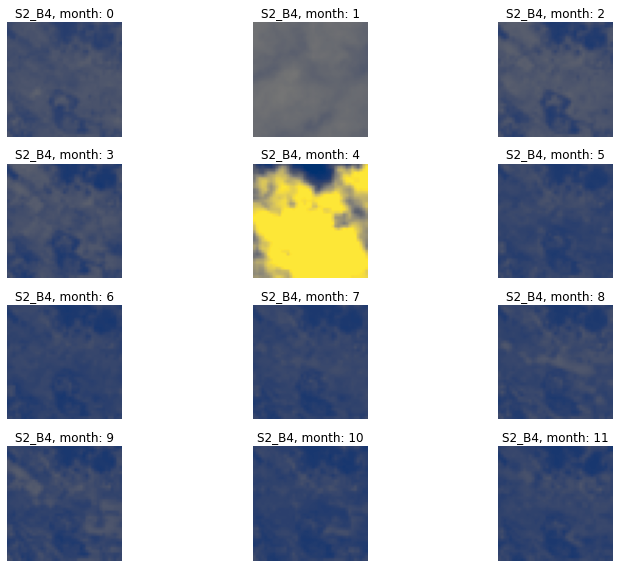

In [ ]:
# Utility dict for mapping of band names to corresponding indices
band_to_idx = get_band_to_idx(BANDS_TXT)

# Random field ID sample
field_sample = train_csv['Field_ID'].sample().values[0]
print(f'Field sample : {field_sample}')

# Load bands data as np.array
field_sample_images = load_np_data(field_sample, TRAIN_DATA_PATH)

# Band of interest, for example red band 664.5-665nm 
BAND = 'S2_B4'
plot_band(field_sample_images, BAND, band_to_idx)

A lot of images suffer form clouds. To deal with clouds few methods are implemented:
* Replace cloudy images with zeros.
* Replace 12 images with `N` average images with ignoring cloudy data. For example, take average of every 4 subsequent bands where cloudy data values are zeros, as a result, band sequence would consist of 3 subsequent average images without clouds.
* Interpolate cloudy data based on clean images. <br>
Cloudy images can be filtered with `QA60` masks or by the threshold value. <br>
Methods mentioned above are implemented in `BandsYieldDataset` class and can be chosen using config file. <br>
Here are few examples below:

In [ ]:
# BandsYieldDataset dataloader config
cfg_data = toml.load('./configs/dataloader_cfg.toml')

# Config with bands statistics
cfg_bands = toml.load('./configs/bands_cfg.toml')

No clouds filtration:

In [ ]:
cfg_data['data_loader']['s2_avg_by'] = 1
cfg_data['data_loader']['filter_clouds'] = False
cfg_data['data_loader']['interpolate'] = False

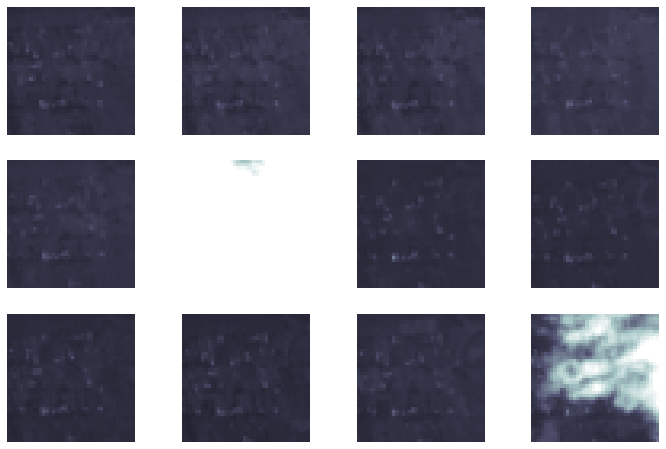

In [ ]:
train_dataset = BandsYieldDataset(
      TRAIN_CSV_PATH,
      TRAIN_DATA_PATH,
      None,
      None,
      cfg_bands,
      cfg_data
  )

sample = train_dataset[2]
plot_sample(sample, cfg_data)

With cloud filtration:

In [ ]:
cfg_data['data_loader']['filter_clouds'] = True

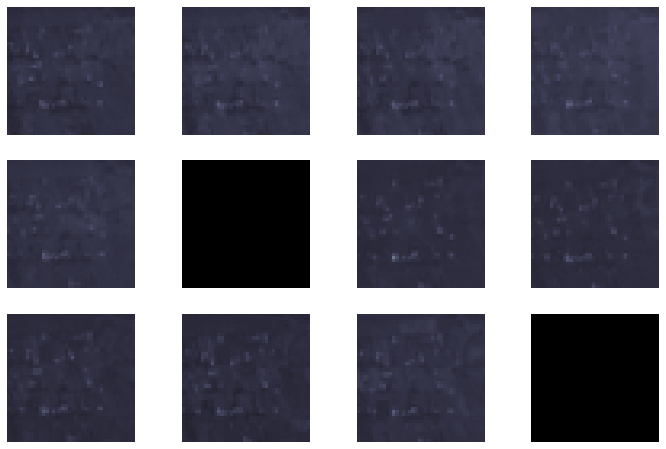

In [ ]:
train_dataset = BandsYieldDataset(
      TRAIN_CSV_PATH,
      TRAIN_DATA_PATH,
      None,
      None,
      cfg_bands,
      cfg_data
  )

sample = train_dataset[2]
plot_sample(sample, cfg_data)

With interpolation:

In [ ]:
cfg_data['data_loader']['interpolate'] = True

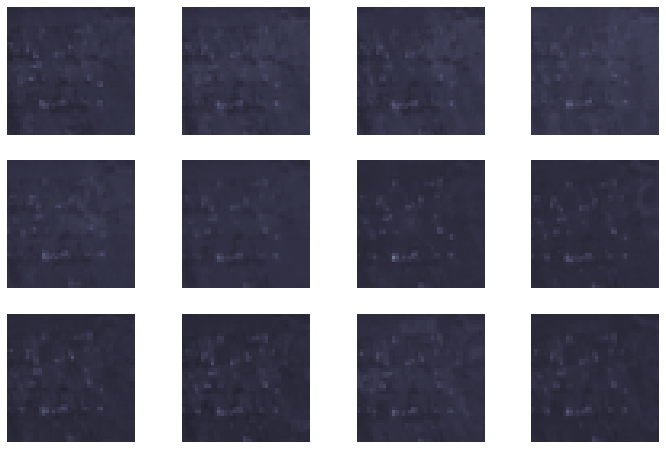

In [ ]:
train_dataset = BandsYieldDataset(
      TRAIN_CSV_PATH,
      TRAIN_DATA_PATH,
      None,
      None,
      cfg_bands,
      cfg_data
  )

sample = train_dataset[2]
plot_sample(sample, cfg_data)

With averaging:

In [ ]:
cfg_data['data_loader']['s2_avg_by'] = 4
cfg_data['data_loader']['interpolate'] = False

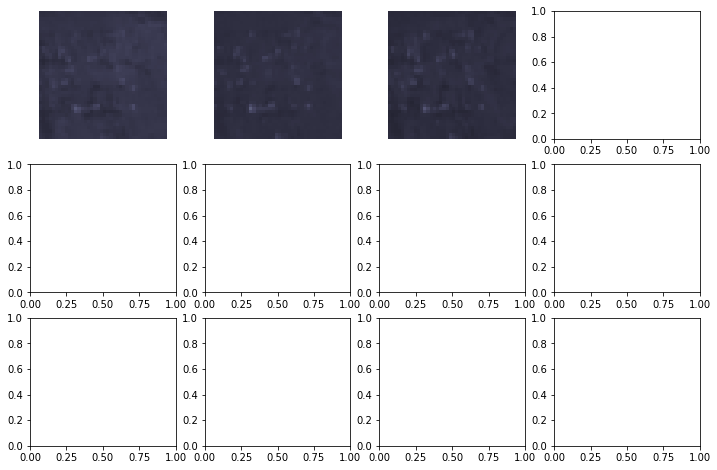

In [ ]:
train_dataset = BandsYieldDataset(
      TRAIN_CSV_PATH,
      TRAIN_DATA_PATH,
      None,
      None,
      cfg_bands,
      cfg_data
  )

sample = train_dataset[2]
plot_sample(sample, cfg_data)

For the image bands following augmentations are implemented:
* Random flip
* Random crop
* Random rotation
* Random cutout (cut random pad form image)
* MixUp (https://paperswithcode.com/method/mixup) <br>
Augmentations parameters and probabilities can be adjusted in `cfg_data['augmentations']`.

In [ ]:
cfg_data['augmentations']

{'crop': {'pad': 25},
 'cutout': {'cut_size': 25, 'n_cuts_max': 3},
 'mixup': {'alpha': 0.4},
 'p_aug': 0.5,
 'p_crop': 0.1,
 'p_cutout': 0.1,
 'p_flip': 0.2,
 'p_mixup': 0.5,
 'p_rotate': 0.1,
 'rotate': {'degrees': 10, 'pad': 5}}

Also transformations such as normalization and resizing are available. <br> For example:

In [ ]:
cfg_data['transforms']

{'s2_band_size': [224, 224], 's2_transforms': ['resize']}

In [ ]:
dataloader_transforms = compose_transforms(cfg_data)
augmentations = create_augmentations(cfg_data)

train_dataset = BandsYieldDataset(
      TRAIN_CSV_PATH,
      TRAIN_DATA_PATH,
      dataloader_transforms,
      augmentations,
      cfg_bands,
      cfg_data
  )

Besides original bands few of satellite indexes can be added via `cfg_data['data_loader']['indexes']`, implemented indexes are:
* NDVI
* NDWI
* EVI2
<br>
For example:

In [ ]:
cfg_data['data_loader']['indexes'] = ['NDVI', 'EVI2']

Besides Santinel bands data `BandsYieldDataset`, a few more data sources are avaliable:
* climate data `cfg_data['data_loader']['clim_bands']` - time series data for climate bands for every month. Available climate bands can be found [here](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE).
* soil data `cfg_data['data_loader']['soil']` - tabular data about soil parameters. Available soil bands properties can be found [here](https://git.wur.nl/isric/soilgrids/soilgrids.notebooks/-/blob/master/markdown/access_on_gee.md). <br>
To utilize them extended train dataset should be used:

In [ ]:
TRAIN_EXTENDED_CSV_PATH = os.path.join(DATA_PATH, 'train_df_full_not_scalled.csv')

train_extended = pd.read_csv(TRAIN_EXTENDED_CSV_PATH)
train_extended.head()

,Field_ID,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,climate_1_aet,climate_1_def,climate_1_pdsi,climate_1_pet,climate_1_pr,climate_1_ro,climate_1_soil,climate_1_srad,climate_1_tmmn,climate_1_tmmx,climate_1_vap,climate_1_vpd,climate_1_vs,climate_2_aet,climate_2_def,climate_2_pdsi,climate_2_pet,climate_2_pr,climate_2_ro,climate_2_soil,climate_2_srad,climate_2_tmmn,climate_2_tmmx,climate_2_vap,climate_2_vpd,climate_2_vs,climate_3_aet,climate_3_def,...,climate_10_pdsi,climate_10_pet,climate_10_pr,climate_10_ro,climate_10_soil,climate_10_srad,climate_10_tmmn,climate_10_tmmx,climate_10_vap,climate_10_vpd,climate_10_vs,climate_11_aet,climate_11_def,climate_11_pdsi,climate_11_pet,climate_11_pr,climate_11_ro,climate_11_soil,climate_11_srad,climate_11_tmmn,climate_11_tmmx,climate_11_vap,climate_11_vpd,climate_11_vs,climate_12_aet,climate_12_def,climate_12_pdsi,climate_12_pet,climate_12_pr,climate_12_ro,climate_12_soil,climate_12_srad,climate_12_tmmn,climate_12_tmmx,climate_12_vap,climate_12_vpd,climate_12_vs,Year,Quality,Yield
0,MH2O0YH,118.0,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,229.0,330.0,119.0,1405.0,370.0,1524.0,4.0,0.0,287.0,2543.0,112.0,285.0,1246.0,138.0,260.0,122.0,1367.0,260.0,1489.0,7.0,0.0,236.0,2609.0,116.0,297.0,1166.0,161.0,260.0,170.0,1464.0,...,-600.0,1191.0,96.0,5.0,99.0,2057.0,109.0,269.0,1637.0,80.0,250.0,791.0,357.0,-570.0,1148.0,83.0,4.0,93.0,2029.0,112.0,271.0,1615.0,85.0,240.0,1067.0,0.0,-400.0,1067.0,125.0,6.0,215.0,1880.0,100.0,267.0,1680.0,69.0,210.0,4,3,3.686
1,O9TURWL,120.0,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,295.0,280.0,115.0,1376.0,410.0,1491.0,4.0,0.0,287.0,2581.0,108.0,288.0,1260.0,138.0,220.0,119.0,1362.0,290.0,1481.0,7.0,0.0,237.0,2639.0,118.0,305.0,1157.0,173.0,230.0,178.0,1518.0,...,-580.0,1228.0,79.0,4.0,102.0,2095.0,109.0,279.0,1640.0,90.0,230.0,743.0,413.0,-540.0,1156.0,78.0,4.0,96.0,2050.0,111.0,280.0,1628.0,93.0,200.0,1078.0,0.0,-360.0,1078.0,126.0,6.0,215.0,1883.0,99.0,273.0,1682.0,75.0,190.0,4,2,5.657
2,35AFSDD,120.0,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,234.0,284.0,111.0,1401.0,410.0,1512.0,4.0,0.0,278.0,2571.0,109.0,288.0,1276.0,137.0,240.0,112.0,1384.0,290.0,1496.0,7.0,0.0,230.0,2629.0,119.0,306.0,1165.0,174.0,240.0,173.0,1548.0,...,-600.0,1240.0,73.0,4.0,100.0,2095.0,110.0,280.0,1644.0,91.0,240.0,718.0,435.0,-560.0,1153.0,75.0,4.0,93.0,2041.0,112.0,280.0,1637.0,93.0,200.0,1084.0,0.0,-360.0,1084.0,135.0,7.0,289.0,1875.0,100.0,274.0,1690.0,76.0,200.0,4,3,3.082
3,PM05EG9,122.0,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,237.0,335.0,123.0,1378.0,370.0,1501.0,3.0,0.0,299.0,2550.0,110.0,282.0,1236.0,134.0,250.0,128.0,1325.0,250.0,1453.0,8.0,0.0,244.0,2612.0,115.0,295.0,1171.0,158.0,240.0,169.0,1475.0,...,-580.0,1161.0,106.0,5.0,102.0,2062.0,108.0,264.0,1648.0,73.0,240.0,826.0,297.0,-550.0,1123.0,86.0,4.0,95.0,2041.0,110.0,268.0,1619.0,81.0,220.0,1053.0,0.0,-390.0,1053.0,121.0,6.0,189.0,1898.0,98.0,263.0,1688.0,64.0,210.0,4,2,2.707
4,V7PZBCG,124.0,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,235.0,187.0,643.0,988.0,270.0,1631.0,20.0,1.0,427.0,2438.0,161.0,320.0,1575.0,173.0,270.0,294.0,1370.0,140.0,1664.0,18.0,1.0,300.0,2576.0,174.0,332.0,1478.0,208.0,290.0,395.0,1409.0,...,-590.0,1250.0,237.0,12.0,1179.0,2057.0,150.0,292.0,1998.0,89.0,240.0,1213.0,34.0,-550.0,1247.0,122.0,6.0,1123.0,2106.0,152.0,296.0,1960.0,99.0,250.0,1199.0,0.0,-380.0,1199.0,194.0,66.0,1214.0,1930.0,143.0,291.0,1972.0,87.0,270.0,4,2,2.679


In [ ]:
cfg_data['data_loader']['clim_bands'] = ['aet', 'pet', 'vap']
cfg_data['data_loader']['soil'] = ['soil_bdod_5-15cm_mean', 'soil_phh2o_5-15cm_mean']

In [ ]:
train_dataset = BandsYieldDataset(
      TRAIN_EXTENDED_CSV_PATH,
      TRAIN_DATA_PATH,
      None,
      None,
      cfg_bands,
      cfg_data
  )

sample = train_dataset[2]

print('Santinel images shape:', sample['s2_bands'].shape)
print('Climate bands shape:', sample['clim_bands'].shape)
print('Soil data shape:', sample['soil_data'].shape)
print('Yield (target) shape:', sample['yield'].shape)

Santinel images shape: torch.Size([21, 40, 40])
Climate bands shape: torch.Size([12, 3])
Soil data shape: torch.Size([2])
Yield (target) shape: torch.Size([])
